## relation extraction 实践
> Tutorial作者：余海阳（yuhaiyang@zju.edu.cn)

在这个演示中，我们使用 `pcnn / gcn / pretrain_language_model` 模型实现中文关系抽取。
希望在这个demo中帮助大家了解知识图谱构建过程中，三元组抽取构建的原理和常用方法。

本demo使用 `python3` 运⾏。

### 数据集
在这个示例中，我们采样了一些中文文本，抽取其中的三元组。

sentence|relation|head|tail
:---:|:---:|:---:|:---:
孔正锡在2005年以一部温馨的爱情电影《长腿叔叔》敲开电影界大门。|导演|长腿叔叔|孔正锡
《伤心的树》是吴宗宪的音乐作品，收录在《你比从前快乐》专辑中。|所属专辑|伤心的树|你比从前快乐
2000年8月，「天坛大佛」荣获「香港十大杰出工程项目」第四名。|所在城市|天坛大佛|香港


- train.csv: 包含6个训练三元组，文件的每一⾏表示一个三元组, 按句子、关系、头实体、尾实体排序，并用`,`分隔。
- valid.csv: 包含3个验证三元组，文件的每一⾏表示一个三元组, 按句子、关系、头实体、尾实体排序，并用`,`分隔。
- test.csv:  包含3个测试三元组，文件的每一⾏表示一个三元组, 按句子、关系、头实体、尾实体排序，并用`,`分隔。
- relation.csv: 包含4种关系三元组，文件的每一⾏表示一个三元组种类, 按头实体种类、尾实体种类、关系、序号排序，并用`,`分隔。

### GCN 原理回顾

![GCN](img/GCN.png)

句子信息主要包括word embedding和position embedding，以及通过语法树得到的邻接矩阵adj_matrix。
该邻接矩阵的点，为每个word token，语法树中相连接的词语构建边。
输入到多层（一般取2，3层，过多层并不会提升结果）图卷积神经网络层后，经过最大池化输入到全连接层，即可得到句子的关系信息。

In [15]:
# 使用pytorch运行神经网络，运行前确认是否安装
!pip install torch
!pip install matplotlib
!pip install transformers

In [2]:
# 导入所使用模块
import os
import csv
import math
import pickle
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics import precision_recall_fscore_support
from typing import List, Tuple, Dict, Any, Sequence, Optional, Union
from transformers import BertTokenizer, BertModel

logger = logging.getLogger(__name__)

In [3]:
# 模型调参的配置文件
class Config(object):
    model_name = 'gcn'  # ['cnn', 'gcn', 'lm']
    use_pcnn = True
    min_freq = 1
    pos_limit = 20
    out_path = 'data/out'   
    batch_size = 2  
    word_dim = 10
    pos_dim = 5
    dim_strategy = 'sum'  # ['sum', 'cat']
    out_channels = 20
    intermediate = 10
    kernel_sizes = [3, 5, 7]
    activation = 'gelu'
    pooling_strategy = 'max'
    dropout = 0.3
    epoch = 10
    num_relations = 4
    learning_rate = 3e-4
    lr_factor = 0.7 # 学习率的衰减率
    lr_patience = 3 # 学习率衰减的等待epoch
    weight_decay = 1e-3 # L2正则
    early_stopping_patience = 6
    train_log = True
    log_interval = 1
    show_plot = True
    only_comparison_plot = False
    plot_utils = 'matplot'
    lm_file = 'bert-base-chinese'
    lm_num_hidden_layers = 2
    rnn_layers = 2
    
cfg = Config()

In [4]:
# word token 构建 one-hot 词典，后续输入到embedding层得到对应word信息矩阵
# 一般默认0为pad，1为unknown
class Vocab(object):
    def __init__(self, name: str = 'basic', init_tokens = ["[PAD]", "[UNK]"]):
        self.name = name
        self.init_tokens = init_tokens
        self.trimed = False
        self.word2idx = {}
        self.word2count = {}
        self.idx2word = {}
        self.count = 0
        self._add_init_tokens()

    def _add_init_tokens(self):
        for token in self.init_tokens:
            self._add_word(token)

    def _add_word(self, word: str):
        if word not in self.word2idx:
            self.word2idx[word] = self.count
            self.word2count[word] = 1
            self.idx2word[self.count] = word
            self.count += 1
        else:
            self.word2count[word] += 1

    def add_words(self, words: Sequence):
        for word in words:
            self._add_word(word)

    def trim(self, min_freq=2, verbose: Optional[bool] = True):
        '''当 word 词频低于 min_freq 时，从词库中删除

        Args:
            param min_freq: 最低词频
        '''
        assert min_freq == int(min_freq), f'min_freq must be integer, can\'t be {min_freq}'
        min_freq = int(min_freq)
        if min_freq < 2:
            return
        if self.trimed:
            return
        self.trimed = True

        keep_words = []
        new_words = []

        for k, v in self.word2count.items():
            if v >= min_freq:
                keep_words.append(k)
                new_words.extend([k] * v)
        if verbose:
            before_len = len(keep_words)
            after_len = len(self.word2idx) - len(self.init_tokens)
            logger.info('vocab after be trimmed, keep words [{} / {}] = {:.2f}%'.format(before_len, after_len, before_len / after_len * 100))

        # Reinitialize dictionaries
        self.word2idx = {}
        self.word2count = {}
        self.idx2word = {}
        self.count = 0
        self._add_init_tokens()
        self.add_words(new_words)

In [5]:
# 预处理过程所需要使用的函数
Path = str

def load_csv(fp: Path, is_tsv: bool = False, verbose: bool = True) -> List:
    if verbose:
        logger.info(f'load csv from {fp}')

    dialect = 'excel-tab' if is_tsv else 'excel'
    with open(fp, encoding='utf-8') as f:
        reader = csv.DictReader(f, dialect=dialect)
        return list(reader)

    
def load_pkl(fp: Path, verbose: bool = True) -> Any:
    if verbose:
        logger.info(f'load data from {fp}')

    with open(fp, 'rb') as f:
        data = pickle.load(f)
        return data


def save_pkl(data: Any, fp: Path, verbose: bool = True) -> None:
    if verbose:
        logger.info(f'save data in {fp}')

    with open(fp, 'wb') as f:
        pickle.dump(data, f)
    
    
def _handle_relation_data(relation_data: List[Dict]) -> Dict:
    rels = dict()
    for d in relation_data:
        rels[d['relation']] = {
            'index': int(d['index']),
            'head_type': d['head_type'],
            'tail_type': d['tail_type'],
        }
    return rels


def _add_relation_data(rels: Dict,data: List) -> None:
    for d in data:
        d['rel2idx'] = rels[d['relation']]['index']
        d['head_type'] = rels[d['relation']]['head_type']
        d['tail_type'] = rels[d['relation']]['tail_type']


def _convert_tokens_into_index(data: List[Dict], vocab):
    unk_str = '[UNK]'
    unk_idx = vocab.word2idx[unk_str]

    for d in data:
        d['token2idx'] = [vocab.word2idx.get(i, unk_idx) for i in d['tokens']]


def _add_pos_seq(train_data: List[Dict], cfg):
    for d in train_data:
        d['head_offset'], d['tail_offset'], d['lens'] = int(d['head_offset']), int(d['tail_offset']), int(d['lens'])
        entities_idx = [d['head_offset'], d['tail_offset']] if d['head_offset'] < d['tail_offset'] else [d['tail_offset'], d['head_offset']]

        d['head_pos'] = list(map(lambda i: i - d['head_offset'], list(range(d['lens']))))
        d['head_pos'] = _handle_pos_limit(d['head_pos'], int(cfg.pos_limit))

        d['tail_pos'] = list(map(lambda i: i - d['tail_offset'], list(range(d['lens']))))
        d['tail_pos'] = _handle_pos_limit(d['tail_pos'], int(cfg.pos_limit))

        if cfg.use_pcnn:
            d['entities_pos'] = [1] * (entities_idx[0] + 1) + [2] * (entities_idx[1] - entities_idx[0] - 1) +\
                                [3] * (d['lens'] - entities_idx[1])

            
def _handle_pos_limit(pos: List[int], limit: int) -> List[int]:
    for i, p in enumerate(pos):
        if p > limit:
            pos[i] = limit
        if p < -limit:
            pos[i] = -limit
    return [p + limit + 1 for p in pos]


def seq_len_to_mask(seq_len: Union[List, np.ndarray, torch.Tensor], max_len=None, mask_pos_to_true=True):
    """
    将一个表示sequence length的一维数组转换为二维的mask，默认pad的位置为1。
    转变 1-d seq_len到2-d mask.

    :param list, np.ndarray, torch.LongTensor seq_len: shape将是(B,)
    :param int max_len: 将长度pad到这个长度。默认(None)使用的是seq_len中最长的长度。但在nn.DataParallel的场景下可能不同卡的seq_len会有
        区别，所以需要传入一个max_len使得mask的长度是pad到该长度。
    :return: np.ndarray, torch.Tensor 。shape将是(B, max_length)， 元素类似为bool或torch.uint8
    """
    if isinstance(seq_len, list):
        seq_len = np.array(seq_len)

    if isinstance(seq_len, np.ndarray):
        seq_len = torch.from_numpy(seq_len)

    if isinstance(seq_len, torch.Tensor):
        assert seq_len.dim() == 1, logger.error(f"seq_len can only have one dimension, got {seq_len.dim()} != 1.")
        batch_size = seq_len.size(0)
        max_len = int(max_len) if max_len else seq_len.max().long()
        broad_cast_seq_len = torch.arange(max_len).expand(batch_size, -1).to(seq_len.device)
        if mask_pos_to_true:
            mask = broad_cast_seq_len.ge(seq_len.unsqueeze(1))
        else:
            mask = broad_cast_seq_len.lt(seq_len.unsqueeze(1))
    else:
        raise logger.error("Only support 1-d list or 1-d numpy.ndarray or 1-d torch.Tensor.")

    return mask


def _lm_serialize(data: List[Dict], cfg):
    logger.info('use bert tokenizer...')
    tokenizer = BertTokenizer.from_pretrained(cfg.lm_file)
    for d in data:
        sent = d['sentence'].strip()
        sent = sent.replace(d['head'], d['head_type'], 1).replace(d['tail'], d['tail_type'], 1)
        sent += '[SEP]' + d['head'] + '[SEP]' + d['tail']
        d['token2idx'] = tokenizer.encode(sent, add_special_tokens=True)
        d['lens'] = len(d['token2idx'])

In [6]:
# 预处理过程
logger.info('load raw files...')
train_fp = os.path.join('data/train.csv')
valid_fp = os.path.join('data/valid.csv')
test_fp = os.path.join('data/test.csv')
relation_fp = os.path.join('data/relation.csv')

train_data = load_csv(train_fp)
valid_data = load_csv(valid_fp)
test_data = load_csv(test_fp)
relation_data = load_csv(relation_fp)

for d in train_data:
    d['tokens'] = eval(d['tokens'])
for d in valid_data:
    d['tokens'] = eval(d['tokens'])
for d in test_data:
    d['tokens'] = eval(d['tokens'])
    
logger.info('convert relation into index...')
rels = _handle_relation_data(relation_data)
_add_relation_data(rels, train_data)
_add_relation_data(rels, valid_data)
_add_relation_data(rels, test_data)

logger.info('verify whether use pretrained language models...')
if cfg.model_name == 'lm':
    logger.info('use pretrained language models serialize sentence...')
    _lm_serialize(train_data, cfg)
    _lm_serialize(valid_data, cfg)
    _lm_serialize(test_data, cfg)
else:
    logger.info('build vocabulary...')
    vocab = Vocab('word')
    train_tokens = [d['tokens'] for d in train_data]
    valid_tokens = [d['tokens'] for d in valid_data]
    test_tokens = [d['tokens'] for d in test_data]
    sent_tokens = [*train_tokens, *valid_tokens, *test_tokens]
    for sent in sent_tokens:
        vocab.add_words(sent)
    vocab.trim(min_freq=cfg.min_freq)

    logger.info('convert tokens into index...')
    _convert_tokens_into_index(train_data, vocab)
    _convert_tokens_into_index(valid_data, vocab)
    _convert_tokens_into_index(test_data, vocab)

    logger.info('build position sequence...')
    _add_pos_seq(train_data, cfg)
    _add_pos_seq(valid_data, cfg)
    _add_pos_seq(test_data, cfg)

logger.info('save data for backup...')
os.makedirs(cfg.out_path, exist_ok=True)
train_save_fp = os.path.join(cfg.out_path, 'train.pkl')
valid_save_fp = os.path.join(cfg.out_path, 'valid.pkl')
test_save_fp = os.path.join(cfg.out_path, 'test.pkl')
save_pkl(train_data, train_save_fp)
save_pkl(valid_data, valid_save_fp)
save_pkl(test_data, test_save_fp)

if cfg.model_name != 'lm':
    vocab_save_fp = os.path.join(cfg.out_path, 'vocab.pkl')
    vocab_txt = os.path.join(cfg.out_path, 'vocab.txt')
    save_pkl(vocab, vocab_save_fp)
    logger.info('save vocab in txt file, for watching...')
    with open(vocab_txt, 'w', encoding='utf-8') as f:
        f.write(os.linesep.join(vocab.word2idx.keys()))

In [7]:
# pytorch 构建自定义 Dataset
class Tree(object):
    def __init__(self):
        self.parent = None
        self.num_children = 0
        self.children = list()

    def add_child(self, child):
        child.parent = self
        self.num_children += 1
        self.children.append(child)

    def size(self):
        s = getattr(self, '_size', -1)
        if s != -1:
            return self._size
        else:
            count = 1
            for i in range(self.num_children):
                count += self.children[i].size()
            self._size = count
            return self._size

    def __iter__(self):
        yield self
        for c in self.children:
            for x in c:
                yield x

    def depth(self):
        d = getattr(self, '_depth', -1)
        if d != -1:
            return self._depth
        else:
            count = 0
            if self.num_children > 0:
                for i in range(self.num_children):
                    child_depth = self.children[i].depth()
                    if child_depth > count:
                        count = child_depth
                count += 1
            self._depth = count
            return self._depth


def head_to_adj(head, directed=False, self_loop=True):
    """
    Convert a sequence of head indexes to an (numpy) adjacency matrix.
    """
    seq_len = len(head)
    head = head[:seq_len]
    root = None
    nodes = [Tree() for _ in head]

    for i in range(seq_len):
        h = head[i]
        setattr(nodes[i], 'idx', i)
        if h == 0:
            root = nodes[i]
        else:
            nodes[h - 1].add_child(nodes[i])

    assert root is not None

    ret = np.zeros((seq_len, seq_len), dtype=np.float32)
    queue = [root]
    idx = []
    while len(queue) > 0:
        t, queue = queue[0], queue[1:]
        idx += [t.idx]
        for c in t.children:
            ret[t.idx, c.idx] = 1
        queue += t.children

    if not directed:
        ret = ret + ret.T

    if self_loop:
        for i in idx:
            ret[i, i] = 1

    return ret


def collate_fn(cfg):
    def collate_fn_intra(batch):
        batch.sort(key=lambda data: int(data['lens']), reverse=True)
        max_len = int(batch[0]['lens'])
        
        def _padding(x, max_len):
            return x + [0] * (max_len - len(x))
        
        def _pad_adj(adj, max_len):
            adj = np.array(adj)
            pad_len = max_len - adj.shape[0]
            for i in range(pad_len):
                adj = np.insert(adj, adj.shape[-1], 0, axis=1)
            for i in range(pad_len):
                adj = np.insert(adj, adj.shape[0], 0, axis=0)
            return adj
        
        x, y = dict(), []
        word, word_len = [], []
        head_pos, tail_pos = [], []
        pcnn_mask = []
        adj_matrix = []
        for data in batch:
            word.append(_padding(data['token2idx'], max_len))
            word_len.append(int(data['lens']))
            y.append(int(data['rel2idx']))
            
            if cfg.model_name != 'lm':
                head_pos.append(_padding(data['head_pos'], max_len))
                tail_pos.append(_padding(data['tail_pos'], max_len))
                if cfg.model_name == 'gcn':
                    head = eval(data['dependency'])
                    adj = head_to_adj(head, directed=True, self_loop=True)
                    adj_matrix.append(_pad_adj(adj, max_len))

                if cfg.use_pcnn:
                    pcnn_mask.append(_padding(data['entities_pos'], max_len))

        x['word'] = torch.tensor(word)
        x['lens'] = torch.tensor(word_len)
        y = torch.tensor(y)
        
        if cfg.model_name != 'lm':
            x['head_pos'] = torch.tensor(head_pos)
            x['tail_pos'] = torch.tensor(tail_pos)
            if cfg.model_name == 'gcn':
                x['adj'] = torch.tensor(adj_matrix)
            if cfg.model_name == 'cnn' and cfg.use_pcnn:
                x['pcnn_mask'] = torch.tensor(pcnn_mask)

        return x, y
    
    return collate_fn_intra


class CustomDataset(Dataset):
    """默认使用 List 存储数据"""
    def __init__(self, fp):
        self.file = load_pkl(fp)

    def __getitem__(self, item):
        sample = self.file[item]
        return sample

    def __len__(self):
        return len(self.file)

In [8]:
# embedding层
class Embedding(nn.Module):
    def __init__(self, config):
        """
        word embedding: 一般 0 为 padding
        pos embedding:  一般 0 为 padding
        dim_strategy: [cat, sum]  多个 embedding 是拼接还是相加
        """
        super(Embedding, self).__init__()

        # self.xxx = config.xxx
        self.vocab_size = config.vocab_size
        self.word_dim = config.word_dim
        self.pos_size = config.pos_limit * 2 + 2
        self.pos_dim = config.pos_dim if config.dim_strategy == 'cat' else config.word_dim
        self.dim_strategy = config.dim_strategy

        self.wordEmbed = nn.Embedding(self.vocab_size,self.word_dim,padding_idx=0)
        self.headPosEmbed = nn.Embedding(self.pos_size,self.pos_dim,padding_idx=0)
        self.tailPosEmbed = nn.Embedding(self.pos_size,self.pos_dim,padding_idx=0)


    def forward(self, *x):
        word, head, tail = x
        word_embedding = self.wordEmbed(word)
        head_embedding = self.headPosEmbed(head)
        tail_embedding = self.tailPosEmbed(tail)

        if self.dim_strategy == 'cat':
            return torch.cat((word_embedding,head_embedding, tail_embedding), -1)
        elif self.dim_strategy == 'sum':
            # 此时 pos_dim == word_dim
            return word_embedding + head_embedding + tail_embedding
        else:
            raise Exception('dim_strategy must choose from [sum, cat]')

In [9]:
# gcn 模型
class GCN(nn.Module):
    def __init__(self, cfg):
        super(GCN, self).__init__()
        self.embedding = Embedding(cfg)
        self.fc1 = nn.Linear(10, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, cfg.num_relations)
        self.dropout = nn.Dropout(cfg.dropout)
        
    def forward(self, x):
        word, adj, head_pos, tail_pos = x['word'], x['adj'], x['head_pos'], x['tail_pos']
        inputs = self.embedding(word, head_pos, tail_pos)
        AxW = F.leaky_relu(self.fc1(torch.bmm(adj,inputs)))
        AxW = self.dropout(AxW)
        AxW = F.leaky_relu(self.fc2(torch.bmm(adj,AxW)))
        AxW = self.dropout(AxW)
        output = self.fc3(torch.bmm(adj,AxW))
        output = torch.max(output, dim=1)[0]
        
        return output

In [10]:
#  p,r,f1 指标测量
class PRMetric():
    def __init__(self):
        """
        暂时调用 sklearn 的方法
        """
        self.y_true = np.empty(0)
        self.y_pred = np.empty(0)

    def reset(self):
        self.y_true = np.empty(0)
        self.y_pred = np.empty(0)

    def update(self, y_true:torch.Tensor, y_pred:torch.Tensor):
        y_true = y_true.cpu().detach().numpy()
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = np.argmax(y_pred,axis=-1)

        self.y_true = np.append(self.y_true, y_true)
        self.y_pred = np.append(self.y_pred, y_pred)

    def compute(self):
        p, r, f1, _ = precision_recall_fscore_support(self.y_true,self.y_pred,average='macro',warn_for=tuple())
        _, _, acc, _ = precision_recall_fscore_support(self.y_true,self.y_pred,average='micro',warn_for=tuple())

        return acc,p,r,f1

In [11]:
# 训练过程中的迭代
def train(epoch, model, dataloader, optimizer, criterion, cfg):
    model.train()

    metric = PRMetric()
    losses = []

    for batch_idx, (x, y) in enumerate(dataloader, 1):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)

        loss.backward()
        optimizer.step()

        metric.update(y_true=y, y_pred=y_pred)
        losses.append(loss.item())

        data_total = len(dataloader.dataset)
        data_cal = data_total if batch_idx == len(dataloader) else batch_idx * len(y)
        if (cfg.train_log and batch_idx % cfg.log_interval == 0) or batch_idx == len(dataloader):
           # p r f1 皆为 macro，因为micro时三者相同，定义为acc
            acc,p,r,f1 = metric.compute()
            print(f'Train Epoch {epoch}: [{data_cal}/{data_total} ({100. * data_cal / data_total:.0f}%)]\t'
                        f'Loss: {loss.item():.6f}')
            print(f'Train Epoch {epoch}: Acc: {100. * acc:.2f}%\t'
                        f'macro metrics: [p: {p:.4f}, r:{r:.4f}, f1:{f1:.4f}]')

    if cfg.show_plot and not cfg.only_comparison_plot:
        if cfg.plot_utils == 'matplot':
            plt.plot(losses)
            plt.title(f'epoch {epoch} train loss')
            plt.show()

    return losses[-1]


# 测试过程中的迭代
def validate(epoch, model, dataloader, criterion,verbose=True):
    model.eval()

    metric = PRMetric()
    losses = []

    for batch_idx, (x, y) in enumerate(dataloader, 1):
        with torch.no_grad():
            y_pred = model(x)
            loss = criterion(y_pred, y)

            metric.update(y_true=y, y_pred=y_pred)
            losses.append(loss.item())

    loss = sum(losses) / len(losses)
    acc,p,r,f1 = metric.compute()
    data_total = len(dataloader.dataset)
    if verbose:
        print(f'Valid Epoch {epoch}: [{data_total}/{data_total}](100%)\t Loss: {loss:.6f}')
        print(f'Valid Epoch {epoch}: Acc: {100. * acc:.2f}%\tmacro metrics: [p: {p:.4f}, r:{r:.4f}, f1:{f1:.4f}]\n\n')

    return f1,loss

In [12]:
# 加载数据集
train_dataset = CustomDataset(train_save_fp)
valid_dataset = CustomDataset(valid_save_fp)
test_dataset = CustomDataset(test_save_fp)

train_dataloader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, collate_fn=collate_fn(cfg))
valid_dataloader = DataLoader(valid_dataset, batch_size=cfg.batch_size, shuffle=True, collate_fn=collate_fn(cfg))
test_dataloader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=True, collate_fn=collate_fn(cfg))

In [13]:
# 因为加载预处理后的数据，才知道vocab_size
vocab = load_pkl(vocab_save_fp)
vocab_size = vocab.count
cfg.vocab_size = vocab_size

GCN(
  (embedding): Embedding(
    (wordEmbed): Embedding(126, 10, padding_idx=0)
    (headPosEmbed): Embedding(42, 10, padding_idx=0)
    (tailPosEmbed): Embedding(42, 10, padding_idx=0)
  )
  (fc1): Linear(in_features=10, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=4, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Train Epoch 1: [2/6 (33%)]	Loss: 0.682893
Train Epoch 1: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 1: [4/6 (67%)]	Loss: 1.612450
Train Epoch 1: Acc: 50.00%	macro metrics: [p: 0.1667, r:0.2500, f1:0.2000]
Train Epoch 1: [6/6 (100%)]	Loss: 2.585485
Train Epoch 1: Acc: 33.33%	macro metrics: [p: 0.1250, r:0.2500, f1:0.1667]


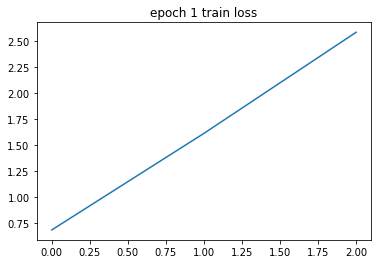

Valid Epoch 1: [3/3](100%)	 Loss: 1.697628
Valid Epoch 1: Acc: 33.33%	macro metrics: [p: 0.2500, r:0.2500, f1:0.2500]


Train Epoch 2: [2/6 (33%)]	Loss: 1.770544
Train Epoch 2: Acc: 50.00%	macro metrics: [p: 0.2500, r:0.5000, f1:0.3333]
Train Epoch 2: [4/6 (67%)]	Loss: 0.942288
Train Epoch 2: Acc: 50.00%	macro metrics: [p: 0.1667, r:0.3333, f1:0.2222]
Train Epoch 2: [6/6 (100%)]	Loss: 2.318838
Train Epoch 2: Acc: 33.33%	macro metrics: [p: 0.1000, r:0.2500, f1:0.1429]


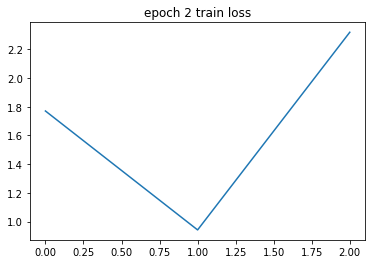

Valid Epoch 2: [3/3](100%)	 Loss: 1.665636
Valid Epoch 2: Acc: 33.33%	macro metrics: [p: 0.1250, r:0.2500, f1:0.1667]


Train Epoch 3: [2/6 (33%)]	Loss: 0.683971
Train Epoch 3: Acc: 50.00%	macro metrics: [p: 0.2500, r:0.5000, f1:0.3333]
Train Epoch 3: [4/6 (67%)]	Loss: 1.514563
Train Epoch 3: Acc: 50.00%	macro metrics: [p: 0.1667, r:0.3333, f1:0.2222]
Train Epoch 3: [6/6 (100%)]	Loss: 1.497782
Train Epoch 3: Acc: 50.00%	macro metrics: [p: 0.4667, r:0.5000, f1:0.4127]


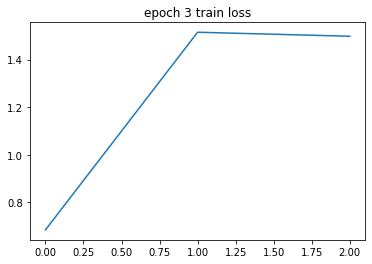

Valid Epoch 3: [3/3](100%)	 Loss: 1.348528
Valid Epoch 3: Acc: 33.33%	macro metrics: [p: 0.1250, r:0.2500, f1:0.1667]


Train Epoch 4: [2/6 (33%)]	Loss: 1.398916
Train Epoch 4: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.3333, f1:0.3333]
Train Epoch 4: [4/6 (67%)]	Loss: 2.822169
Train Epoch 4: Acc: 25.00%	macro metrics: [p: 0.1250, r:0.2500, f1:0.1667]
Train Epoch 4: [6/6 (100%)]	Loss: 1.129586
Train Epoch 4: Acc: 33.33%	macro metrics: [p: 0.1667, r:0.2500, f1:0.2000]


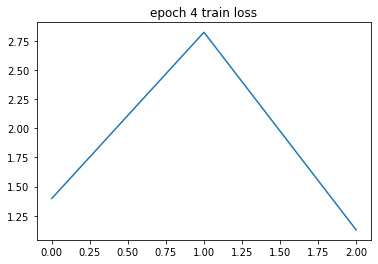

Valid Epoch 4: [3/3](100%)	 Loss: 1.617668
Valid Epoch 4: Acc: 33.33%	macro metrics: [p: 0.1250, r:0.2500, f1:0.1667]


Train Epoch 5: [2/6 (33%)]	Loss: 2.088744
Train Epoch 5: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]
Train Epoch 5: [4/6 (67%)]	Loss: 0.552232
Train Epoch 5: Acc: 50.00%	macro metrics: [p: 0.3750, r:0.3750, f1:0.3750]
Train Epoch 5: [6/6 (100%)]	Loss: 1.952725
Train Epoch 5: Acc: 33.33%	macro metrics: [p: 0.3750, r:0.2500, f1:0.2917]


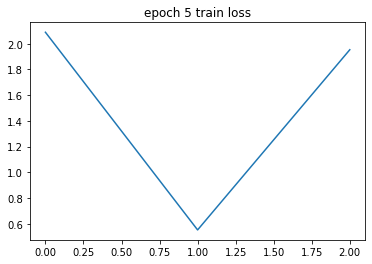

Valid Epoch 5: [3/3](100%)	 Loss: 1.314117
Valid Epoch 5: Acc: 33.33%	macro metrics: [p: 0.1250, r:0.2500, f1:0.1667]


Train Epoch 6: [2/6 (33%)]	Loss: 1.916540
Train Epoch 6: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]
Train Epoch 6: [4/6 (67%)]	Loss: 1.380667
Train Epoch 6: Acc: 25.00%	macro metrics: [p: 0.1250, r:0.1250, f1:0.1250]
Train Epoch 6: [6/6 (100%)]	Loss: 1.332682
Train Epoch 6: Acc: 16.67%	macro metrics: [p: 0.1250, r:0.1250, f1:0.1250]


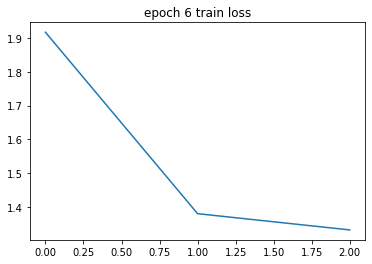

Valid Epoch 6: [3/3](100%)	 Loss: 1.194998
Valid Epoch 6: Acc: 33.33%	macro metrics: [p: 0.1250, r:0.2500, f1:0.1667]


Train Epoch 7: [2/6 (33%)]	Loss: 1.310221
Train Epoch 7: Acc: 50.00%	macro metrics: [p: 0.2500, r:0.5000, f1:0.3333]
Train Epoch 7: [4/6 (67%)]	Loss: 1.471952
Train Epoch 7: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.6667, f1:0.4444]
Train Epoch 7: [6/6 (100%)]	Loss: 3.029135
Train Epoch 7: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.5000, f1:0.3889]


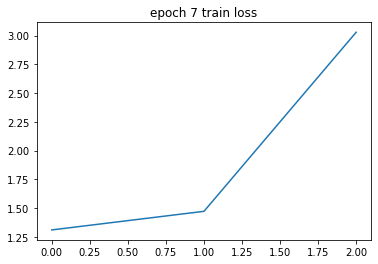

Valid Epoch 7: [3/3](100%)	 Loss: 1.292672
Valid Epoch 7: Acc: 33.33%	macro metrics: [p: 0.1250, r:0.2500, f1:0.1667]


Train Epoch 8: [2/6 (33%)]	Loss: 1.309818
Train Epoch 8: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]
Train Epoch 8: [4/6 (67%)]	Loss: 1.509405
Train Epoch 8: Acc: 25.00%	macro metrics: [p: 0.1667, r:0.1667, f1:0.1667]
Train Epoch 8: [6/6 (100%)]	Loss: 2.100271
Train Epoch 8: Acc: 16.67%	macro metrics: [p: 0.0833, r:0.1250, f1:0.1000]


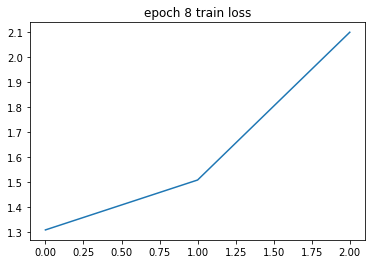

Valid Epoch 8: [3/3](100%)	 Loss: 1.284388
Valid Epoch 8: Acc: 66.67%	macro metrics: [p: 0.5000, r:0.6667, f1:0.5556]


Train Epoch 9: [2/6 (33%)]	Loss: 1.078659
Train Epoch 9: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.3333, f1:0.3333]
Train Epoch 9: [4/6 (67%)]	Loss: 1.559893
Train Epoch 9: Acc: 50.00%	macro metrics: [p: 0.3750, r:0.3750, f1:0.3750]
Train Epoch 9: [6/6 (100%)]	Loss: 0.969534
Train Epoch 9: Acc: 50.00%	macro metrics: [p: 0.3750, r:0.3750, f1:0.3750]


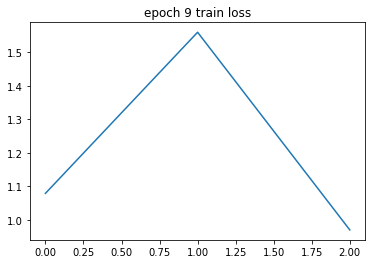

Valid Epoch 9: [3/3](100%)	 Loss: 1.283270
Valid Epoch 9: Acc: 66.67%	macro metrics: [p: 0.5000, r:0.6667, f1:0.5556]


Train Epoch 10: [2/6 (33%)]	Loss: 1.265285
Train Epoch 10: Acc: 50.00%	macro metrics: [p: 0.2500, r:0.5000, f1:0.3333]
Train Epoch 10: [4/6 (67%)]	Loss: 1.862774
Train Epoch 10: Acc: 50.00%	macro metrics: [p: 0.4444, r:0.6667, f1:0.5000]
Train Epoch 10: [6/6 (100%)]	Loss: 0.461010
Train Epoch 10: Acc: 66.67%	macro metrics: [p: 0.5000, r:0.6667, f1:0.5556]


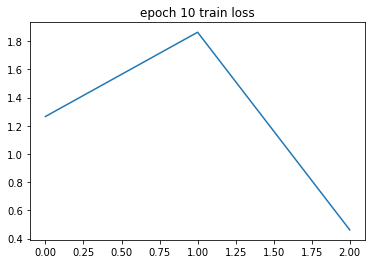

Valid Epoch 10: [3/3](100%)	 Loss: 1.286785
Valid Epoch 10: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]




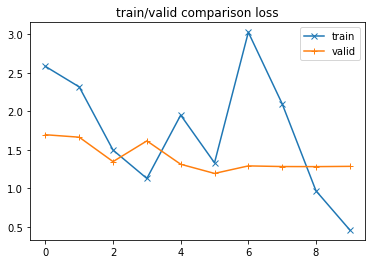

best(valid loss quota) early stopping epoch: 6, this epoch macro f1: 0.1667
total 10 epochs, best(valid macro f1) epoch: 8, this epoch macro f1: 0.5556
after 10 epochs, final test data macro f1: 0.5556


In [14]:
# main 入口，定义优化函数、loss函数等
# 开始epoch迭代
# 使用valid 数据集的loss做早停判断，当不再下降时，此时为模型泛化性最好的时刻。
model = GCN(cfg)
print(model)

optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=cfg.lr_factor, patience=cfg.lr_patience)
criterion = nn.CrossEntropyLoss()

best_f1, best_epoch = -1, 0
es_loss, es_f1, es_epoch, es_patience, best_es_epoch, best_es_f1, = 1000, -1, 0, 0, 0, -1
train_losses, valid_losses = [], []

logger.info('=' * 10 + ' Start training ' + '=' * 10)
for epoch in range(1, cfg.epoch + 1):
    train_loss = train(epoch, model, train_dataloader, optimizer, criterion, cfg)
    valid_f1, valid_loss = validate(epoch, model, valid_dataloader, criterion)
    scheduler.step(valid_loss)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    if best_f1 < valid_f1:
        best_f1 = valid_f1
        best_epoch = epoch
    # 使用 valid loss 做 early stopping 的判断标准
    if es_loss > valid_loss:
        es_loss = valid_loss
        es_f1 = valid_f1
        best_es_f1 = valid_f1
        es_epoch = epoch
        best_es_epoch = epoch
        es_patience = 0
    else:
        es_patience += 1
        if es_patience >= cfg.early_stopping_patience:
            best_es_epoch = es_epoch
            best_es_f1 = es_f1

if cfg.show_plot:
    if cfg.plot_utils == 'matplot':
        plt.plot(train_losses, 'x-')
        plt.plot(valid_losses, '+-')
        plt.legend(['train', 'valid'])
        plt.title('train/valid comparison loss')
        plt.show()


print(f'best(valid loss quota) early stopping epoch: {best_es_epoch}, '
            f'this epoch macro f1: {best_es_f1:0.4f}')
print(f'total {cfg.epoch} epochs, best(valid macro f1) epoch: {best_epoch}, '
            f'this epoch macro f1: {best_f1:.4f}')

test_f1, _ = validate(0, model, test_dataloader, criterion,verbose=False)
print(f'after {cfg.epoch} epochs, final test data macro f1: {test_f1:.4f}')

本demo不包括调参部分，有兴趣的同学可以自行前往 [deepke](http://openkg.cn/tool/deepke) 仓库，下载使用更多的模型 :)